In [24]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [30]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [11]:
dimension = 100
rho0_l = 20
rho0_s = 3
dx = 1
H = np.eye(dimension)[::2]
y_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

In [12]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_exp_1d,
    return_Corr=True, return_sort_ind=True)
eig_val_l = eig_val_l*(dimension/eig_val_l.sum())
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = P_l.real
#P_l = P_l/P_l.max()

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
eig_val_s = eig_val_s*(dimension/eig_val_s.sum())
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = P_s.real
#P_s = P_s/P_s.max()

eig_val = 0.5 * (eig_val_s + eig_val_l)
eig_vec = eig_vec_l.copy()

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
eig_val = eig_val/P.max()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(y_size)

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt, P_inv_sqrt = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U, S, VT = returned[4:7]
Tx, Tx_inv, Ty, Ty_inv = returned[7:]


returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)

P_sqrt_l, P_inv_sqrt_l = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U_l, S_l, VT_l = returned[4:7]
Tx_l, Tx_inv_l, Ty_l, Ty_inv_l = returned[7:]

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt_s, P_inv_sqrt_s = returned[:2]
R_sqrt_s, R_inv_sqrt_s = returned[2:4]
U, S, VT = returned[4:7]
Tx, Tx_inv, Ty, Ty_inv = returned[7:]

<IPython.core.display.Javascript object>


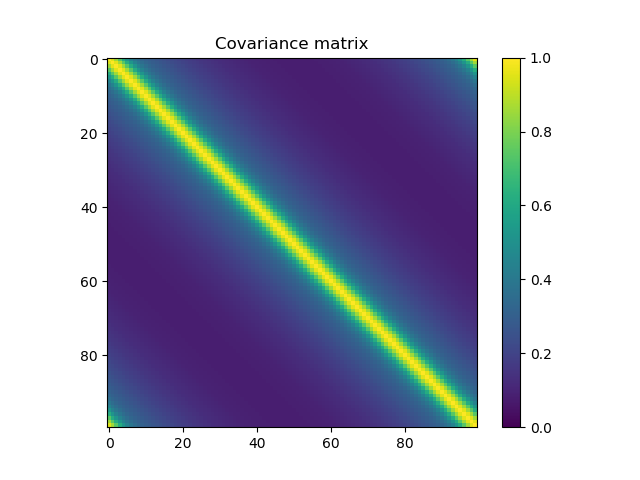

<IPython.core.display.Javascript object>


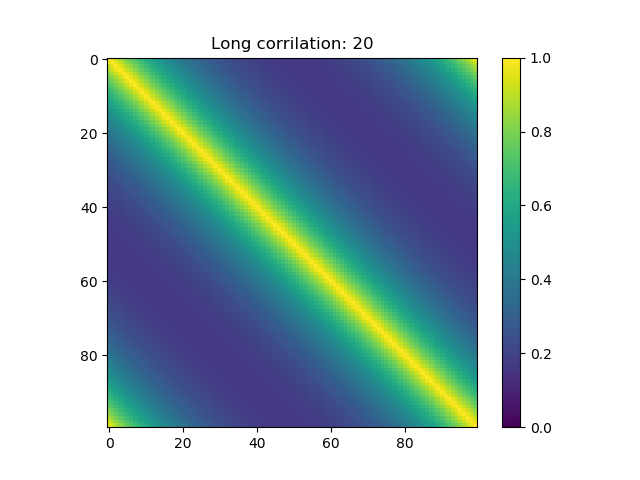

<IPython.core.display.Javascript object>


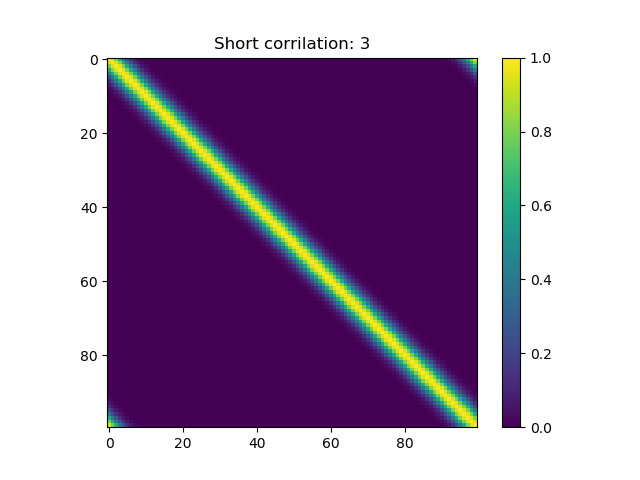

Log10(condition):  3.671521153580899


In [13]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

<IPython.core.display.Javascript object>


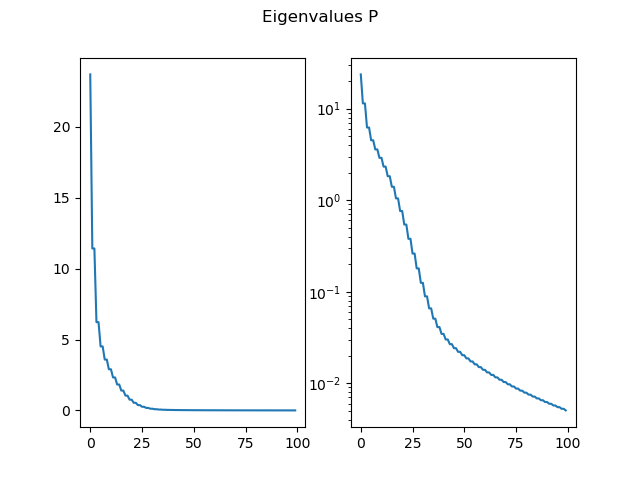

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


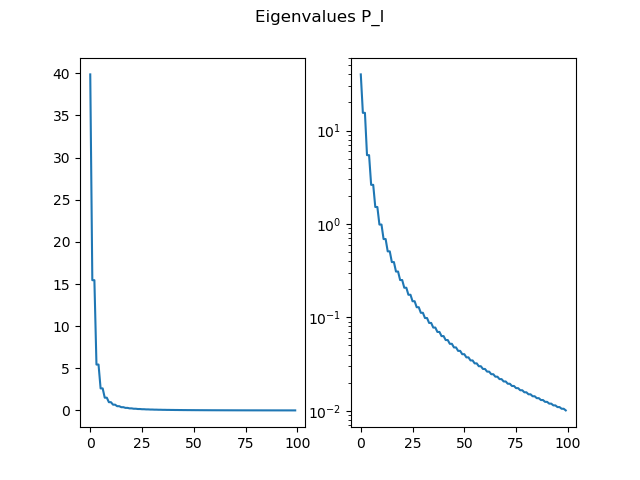

<IPython.core.display.Javascript object>


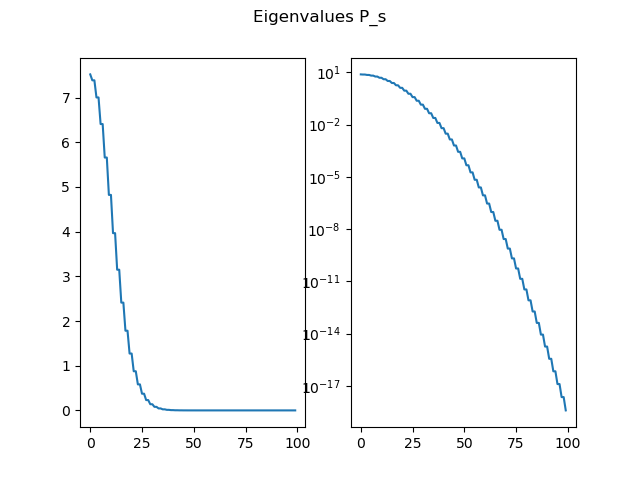

Text(0.5,0.98,'Eigenvalues P_s')

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

In [5]:
eig_val, eig_vec, P = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_exp_1d,
    return_Corr = True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(y_size)

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt, P_inv_sqrt = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U, S, VT = returned[4:7]
Tx, Tx_inv, Ty, Ty_inv = returned[7:]

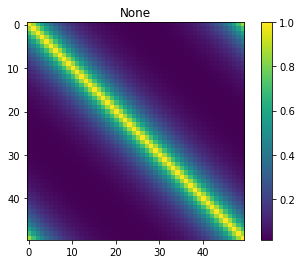

In [6]:
imshow(P)

10.420941070311047


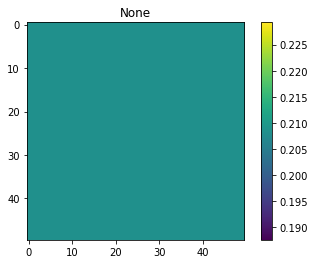

In [7]:
imshow((eig_val[0]*eig_vec[:, 0][:, None] @ eig_vec[:, 0][:, None].conj().T).real)
print(eig_val[0])

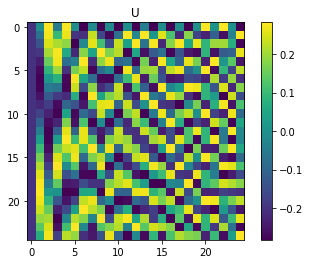

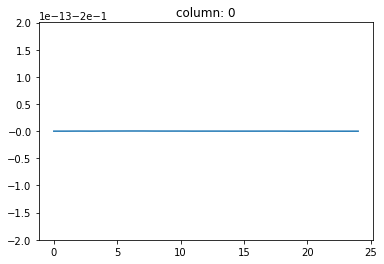

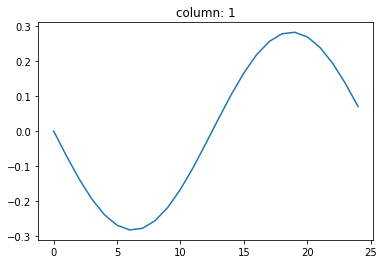

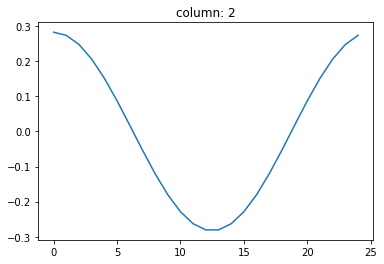

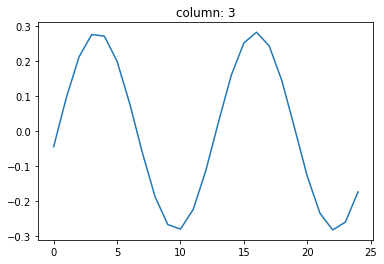

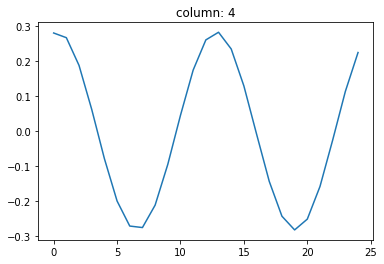

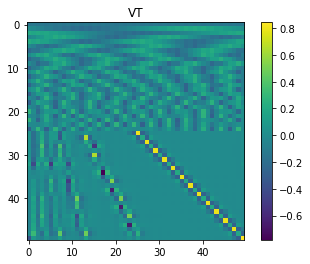

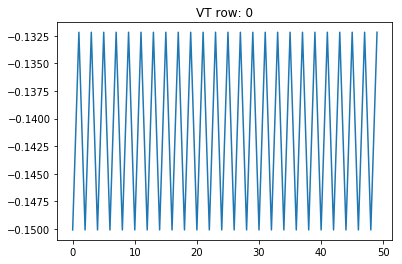

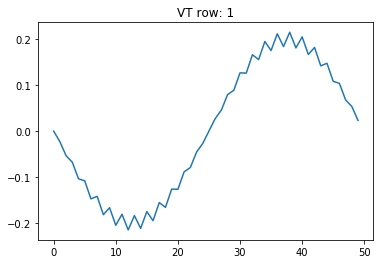

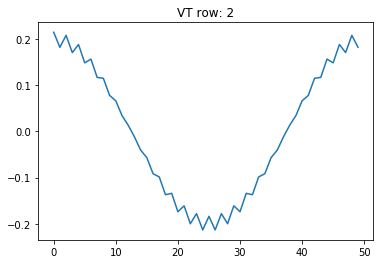

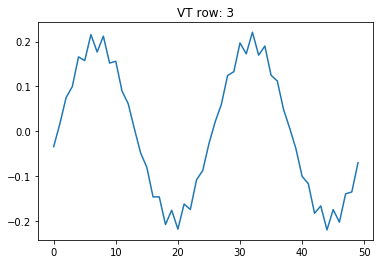

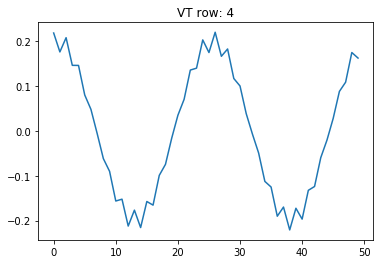

In [8]:
imshow(U, 'U')

for ii in range(5):   
    plt.figure()
    plt.plot(U[:, ii])
    plt.title(f'column: {ii}')
    
imshow(VT, 'VT')

for ii in range(5):
    plt.figure()
    plt.plot(VT[ii])
    plt.title(f'VT row: {ii}')

In [17]:
ens_size = int(1e2)
obs_size = int(1e3)

In [18]:
mu = np.zeros(dimension)
X_ens = assimilate.generate_ensemble(
    ens_size, mu, P_sqrt)
ground_truth = assimilate.generate_ensemble(
    1, mu, P_sqrt)
Y_ens = H @ ground_truth + R_sqrt @ np.random.randn(y_size, obs_size)

In [19]:
X_ens_p = Tx @ X_ens
Y_ens_p = Ty @ Y_ens

In [20]:
sigma=1000
# X_smooth = ndimage.gaussian_filter1d(
#     X_ens, sigma=sigma, axis=0, mode='wrap')
X_smooth = np.repeat(X_ens.mean(axis=0)[None, :], dimension, axis=0)

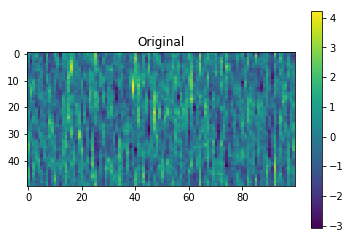

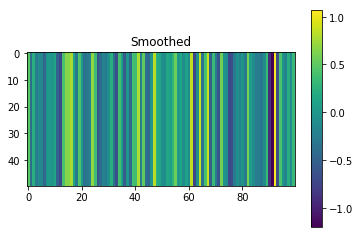

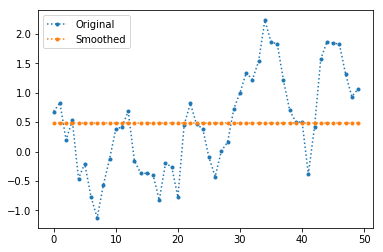

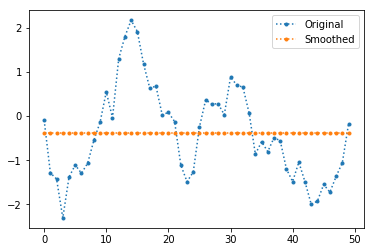

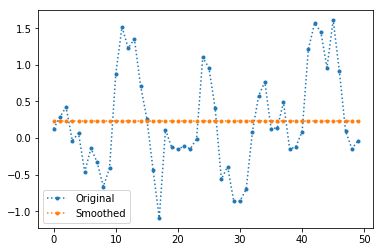

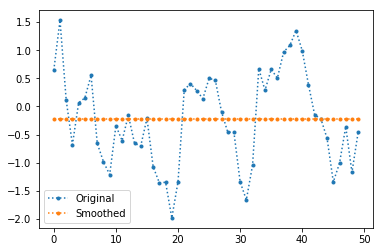

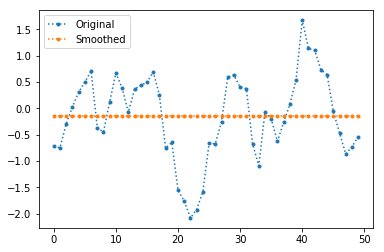

In [21]:
imshow(X_ens, 'Original')
imshow(X_smooth, 'Smoothed')

for ii in range(5):
    plt.figure()
    plt.plot(X_ens[:, ii], ':', marker='.')
    plt.plot(X_smooth[:, ii], ':', marker='.')
    plt.legend(['Original', 'Smoothed'])

In [22]:
np.var(X_smooth[0])

0.19374195939378672

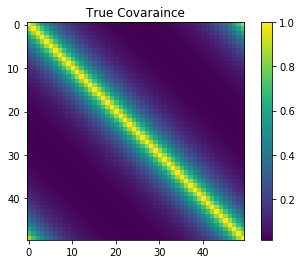

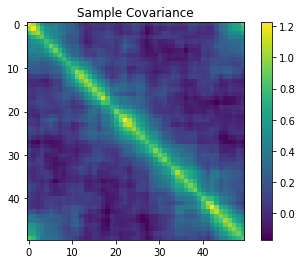

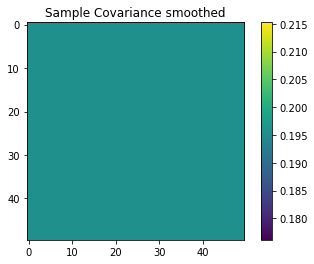

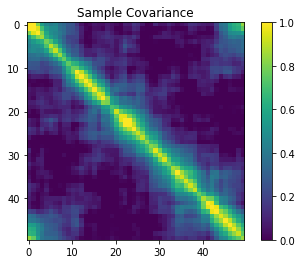

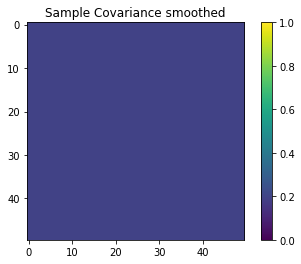

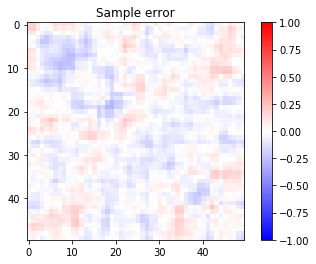

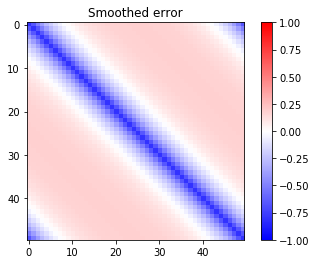

In [23]:
P_sample = np.cov(X_ens)
P_smooth = np.cov(X_smooth)
imshow(P, 'True Covaraince')

imshow(P_sample, 'Sample Covariance')
imshow(P_smooth, 'Sample Covariance smoothed')

imshow(P_sample, 'Sample Covariance', vmin=0, vmax=1)
imshow(P_smooth, 'Sample Covariance smoothed', vmin=0, vmax=1)

imshow(P_sample - P, 'Sample error', vmin=-1, vmax=1, cmap='bwr')
imshow(P_smooth - P, 'Smoothed error', vmin=-1, vmax=1, cmap='bwr')


In [24]:
eig_val[0] * 1/dimension

0.20841882140622092